In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [2]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN_AttributeMask', 'GCN_', 'GraphSAGE_', 'GraphSAGE_AttributeMask', 
          'GCN_CorruptedEmbeddingsReconstruction', 'GCN_CorruptedFeaturesReconstruction', 'GCN_AutoEncoding',
         'GCN_GAE','GCN_VGAE','GCN_ARGA','GCN_ARGVA']
METRIC = 'test_rocauc_ovr'

In [3]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [4]:
results_df.columns[50:60]

Index(['GCN_AttributeMask_train_epochs', 'GCN_AttributeMask_train_lr',
       'GCN_AttributeMask_train_lambda', 'GCN_AttributeMask_model_in_channels',
       'GCN_AttributeMask_model_hidden_channels',
       'GCN_AttributeMask_model_num_layers', 'GCN_AttributeMask_model_dropout',
       'GCN_AttributeMask_model_node_mask_ratio',
       'GCN_AttributeMask_model_out_channels',
       'GCN_CorruptedFeaturesReconstruction_num_tuning_rounds'],
      dtype='object')

In [11]:
results_df['GCN_AttributeMask_train_lambda']

0     0.100
1     0.100
2     0.001
3     0.010
4     0.001
0     0.001
1    10.000
2     0.010
3     0.100
4     0.001
0     0.100
1    10.000
2     0.100
3     0.001
4     0.100
0     1.000
1    10.000
2     0.100
3     1.000
4     0.001
0    10.000
1     0.100
2     0.001
3     1.000
4     0.010
0    10.000
1     1.000
2     1.000
3    10.000
4     1.000
0     0.010
1     0.001
2     0.100
3     1.000
4     0.001
0     1.000
1     0.001
2     1.000
3    10.000
4     1.000
0     1.000
1     1.000
2     0.010
3    10.000
4     0.010
0     0.001
1     0.100
2     0.001
3     1.000
4    10.000
Name: GCN_AttributeMask_train_lambda, dtype: float64

In [6]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

In [7]:
results_df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,GCN__test_rocauc_ovo,GCN__test_logloss,GCN__train_epochs,GCN__train_lr,GCN__train_lambda,GCN__model_in_channels,GCN__model_hidden_channels,GCN__model_num_layers,GCN__model_dropout,GCN__model_out_channels
0,204,9.696078,2.028935,16,2.0,2,58.173894,4,0.993417,3.0,...,0.966718,0.597064,100,0.010,0.100,16,8,3,0.8,4
1,495,9.456033,1.126157,16,2.0,2,33.709380,4,0.791116,3.0,...,0.939542,0.456053,100,0.010,0.001,16,16,4,0.8,4
2,466,9.412527,3.844537,16,2.0,2,12.456467,4,0.846166,3.0,...,0.987640,0.236448,100,0.010,0.010,16,16,1,0.0,4
3,329,9.161095,4.128867,16,2.0,2,51.494350,4,0.344994,3.0,...,0.904891,4.518073,100,0.010,10.000,16,4,1,0.5,4
4,335,10.089820,2.986774,16,2.0,2,36.012089,4,0.425467,3.0,...,0.992913,0.241581,100,0.001,0.100,16,16,2,0.3,4
0,340,12.264706,3.041322,16,2.0,2,1.102087,4,0.707128,3.0,...,0.673264,8.551860,100,0.010,10.000,16,16,2,0.0,4
1,366,8.120548,1.618883,16,2.0,2,59.176619,4,0.931328,3.0,...,0.974747,0.246088,100,0.001,10.000,16,16,3,0.0,4
2,506,12.163346,2.403579,16,2.0,2,6.566536,4,0.735834,3.0,...,0.933045,0.731204,100,0.010,0.010,16,8,1,0.0,4
3,266,9.646617,2.320715,16,2.0,2,32.577301,4,0.090479,3.0,...,0.950490,1.109717,100,0.010,10.000,16,4,3,0.0,4
4,338,11.869823,4.576888,16,2.0,2,48.095270,4,0.333370,3.0,...,0.991415,0.645131,100,0.010,0.010,16,16,1,0.8,4


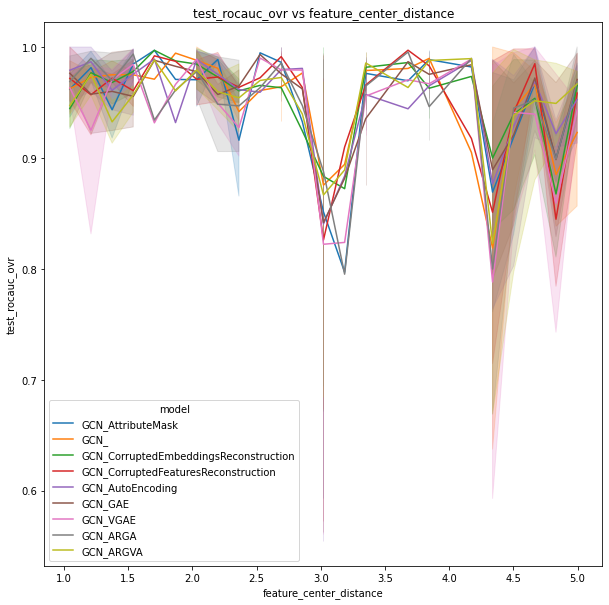

In [9]:
plot_response_surface1d('feature_center_distance', METRIC, results_df)